Medicare fraud detection with K-means Clustering

- Revising Features
- Normalizing Data
- Finding an optimal number of clusters
- K-means Clustering

The logic behind the feature selection is to select features that might take unusually large or small values in the event of anomalies

In [2]:
library(dplyr)
library(DataExplorer)
library(ggplot2)
library(plotly)
library(data.table)
library(zipcode)
suppressPackageStartupMessages(library(tidyverse))
library(stringr)
suppressPackageStartupMessages(library(maps))
library(leaflet)
library(gridExtra)
require(gridExtra)
library(cowplot)

In [2]:
payment <- read.csv("inpatientCharges.csv")
data(zipcode)

In [3]:
payment$Average.Covered.Charges <- as.numeric(sub("\\$","", payment$Average.Covered.Charges))
payment$Average.Medicare.Payments <- as.numeric(sub("\\$","", payment$Average.Medicare.Payments))
payment$Average.Total.Payments <- as.numeric(sub("\\$","", payment$Average.Total.Payments))

- Means by cities - 

This time I decided to revise my variables and  calculate metrics by cities instead of State, because of price variabilities between cities within a State.

In [4]:
drg.by.city <- payment %>% group_by(DRG.Definition, Provider.City) %>%
        summarise(count =n(),
                  city.mean.total.discharges          = mean(Total.Discharges),
                  city.mean.average.covered.charges   = mean(Average.Covered.Charges),
                  city.mean.average.total.payments    = mean(Average.Total.Payments),
                  city.mean.average.medicare.payments = mean(Average.Medicare.Payments))
                 
dim(drg.by.city); 

[1] 105823      7

- Ratios by cities -

In [5]:
per_provider <- payment %>% 
       left_join(drg.by.city, by=c("DRG.Definition","Provider.City")) %>%
       mutate( 
            ratio.total.discharges          = Total.Discharges/city.mean.total.discharges,
            ratio.average.covered.charges   = Average.Covered.Charges/city.mean.average.covered.charges,
            ratio.average.total.payments    = Average.Total.Payments/city.mean.average.total.payments,
            ratio.average.medicare.payments = Average.Medicare.Payments/city.mean.average.medicare.payments) %>%
       select(-city.mean.total.discharges,
              -city.mean.average.covered.charges,
              -city.mean.average.total.payments,
              -city.mean.average.medicare.payments,
              -count,
              -Total.Discharges,
              -Average.Covered.Charges,
              -Average.Total.Payments,
              -Average.Medicare.Payments)%>%
arrange(Provider.Id, DRG.Definition) 

- Average.Medicare.Payments / Average.Covered.Charges -

Total payment stream comes from customer, private insurance and medicare. private insurance and medicare payments are more sussaptible to fraud, because the customer is more price sensitive, so procedures with higher medicare reinbursment level might be a target.

In [6]:
charges <- payment %>%
    mutate(payments.to.charges = Average.Medicare.Payments / Average.Covered.Charges) %>%
    group_by(Provider.Id, DRG.Definition) %>%
    arrange(Provider.Id)

In [7]:
head(charges$payments.to.charges)

[1] 0.1445172 0.1902989 0.2361409 0.1988839 0.2055567 0.1500036

In [8]:
per_provider$payments.to.charges <- charges$payments.to.charges

- number of DRGs by Provider.Id

Many medical conditions have the different levels of accuity, for providers with different levels of DRG it will be easy to charge with higher prices or reimbursement level treatment. So providers with different accuting or treatment levels are more prone to upcharging.

In [9]:
number.of.drgs <- payment %>% group_by(Provider.Id) %>%
  mutate(numberofDRGs1 = n_distinct(DRG.Definition),
        numberofDRGs = numberofDRGs1/100) %>%
arrange(Provider.Id)

In [10]:
per_provider$numberofDRGs <- number.of.drgs$numberofDRGs

- By Provider categorical metrics (above and below city&drg averages)

In [750]:
aab <- per_provider %>%
        select(Provider.Id, DRG.Definition, Provider.State, ratio.average.medicare.payments) %>%
        arrange(ratio.average.medicare.payments) %>%
        mutate(Avg = mean(1, na.rm = TRUE),
               Ratio = ifelse(ratio.average.medicare.payments - Avg > 0, "Above the State Average", "Below the State Average"))%>%
             arrange(desc(ratio.average.medicare.payments))
head(aab, 5)


aab2 <- per_provider %>%
        select(Provider.Id, DRG.Definition, Provider.State, ratio.average.total.payments) %>%
        arrange(ratio.average.total.payments) %>%
        mutate(Avg = mean(1, na.rm = TRUE),
               Ratio = ifelse(ratio.average.total.payments - Avg > 0, "Above the State Average", "Below the State Average"))%>%
             arrange(desc(ratio.average.total.payments))
head(aab2, 5)

aab3 <- per_provider %>%
        select(Provider.Id, DRG.Definition, Provider.State, ratio.average.covered.charges) %>%
        arrange(ratio.average.covered.charges) %>%
        mutate(Avg = mean(1, na.rm = TRUE),
               Ratio = ifelse(ratio.average.covered.charges - Avg > 0, "Above the State Average", "Below the State Average"))%>%
             arrange(desc(ratio.average.covered.charges))
head(aab3, 5)

aab4 <- per_provider %>%
        select(Provider.Id, DRG.Definition, Provider.State, ratio.total.discharges) %>%
        arrange(ratio.total.discharges) %>%
        mutate(Avg = mean(1, na.rm = TRUE),
               Ratio = ifelse(ratio.total.discharges - Avg > 0, "Above the State Average", "Below the State Average"))%>%
             arrange(desc(ratio.total.discharges))
head(aab4, 5)



Provider.Id,DRG.Definition,Provider.State,ratio.average.medicare.payments,Avg,Ratio
210009,202 - BRONCHITIS & ASTHMA W CC/MCC,MD,3.846861,1,Above the State Average
370220,491 - BACK & NECK PROC EXC SPINAL FUSION W/O CC/MCC,OK,2.770988,1,Above the State Average
210009,885 - PSYCHOSES,MD,2.594458,1,Above the State Average
210009,699 - OTHER KIDNEY & URINARY TRACT DIAGNOSES W CC,MD,2.568066,1,Above the State Average
330350,377 - G.I. HEMORRHAGE W MCC,NY,2.447406,1,Above the State Average


Provider.Id,DRG.Definition,Provider.State,ratio.average.total.payments,Avg,Ratio
210009,202 - BRONCHITIS & ASTHMA W CC/MCC,MD,3.753099,1,Above the State Average
390312,948 - SIGNS & SYMPTOMS W/O MCC,PA,3.469059,1,Above the State Average
210009,885 - PSYCHOSES,MD,2.556468,1,Above the State Average
210009,699 - OTHER KIDNEY & URINARY TRACT DIAGNOSES W CC,MD,2.533605,1,Above the State Average
330350,377 - G.I. HEMORRHAGE W MCC,NY,2.466861,1,Above the State Average


Provider.Id,DRG.Definition,Provider.State,ratio.average.covered.charges,Avg,Ratio
210009,202 - BRONCHITIS & ASTHMA W CC/MCC,MD,3.759354,1,Above the State Average
330214,101 - SEIZURES W/O MCC,NY,3.640652,1,Above the State Average
360085,314 - OTHER CIRCULATORY SYSTEM DIAGNOSES W MCC,OH,2.968802,1,Above the State Average
50496,300 - PERIPHERAL VASCULAR DISORDERS W CC,CA,2.953029,1,Above the State Average
50373,885 - PSYCHOSES,CA,2.838189,1,Above the State Average


Provider.Id,DRG.Definition,Provider.State,ratio.total.discharges,Avg,Ratio
450184,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W MCC,TX,5.689303,1,Above the State Average
360247,897 - ALCOHOL/DRUG ABUSE OR DEPENDENCE W/O REHABILITATION THERAPY W/O MCC,OH,5.661741,1,Above the State Average
50625,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC,CA,5.622857,1,Above the State Average
330270,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC,NY,5.508775,1,Above the State Average
80001,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC,DE,5.438583,1,Above the State Average


- At the end, for K-means clustering I decided to use 6 variables.

In [751]:
data <- select(per_provider, Provider.Id, numberofDRGs, payments.to.charges, ratio.total.discharges, ratio.average.covered.charges,
               ratio.average.total.payments, ratio.average.medicare.payments)

In [752]:
train <- select(per_provider, ratio.total.discharges, ratio.average.covered.charges,
               ratio.average.total.payments, ratio.average.medicare.payments, numberofDRGs, payments.to.charges)

In [753]:
train <- scale(train)

- Choosing optimal number of clusters -

Setting k to be very large will improve the homogeneity of the clusters, and at the same time, it risks overfitting the data.k-means is sensitive to the number of clusters; 


The Elbow method considers the total within-cluster sum of square (total WSS) as a function of the number of clusters, but sometimes it does not give clear results

In [695]:
value_k=c()
value_metric=c()

data=train
for (i in 2:20){
    km = kmeans(train, i)
    value_k=c(value_k,i)
    metric = km$tot.withinss/km$totss
    value_metric=c(value_metric, metric)
}

Warning message:
"did not converge in 10 iterations"Warning message:
"did not converge in 10 iterations"Warning message:
"did not converge in 10 iterations"Warning message:
"did not converge in 10 iterations"Warning message:
"did not converge in 10 iterations"Warning message:
"did not converge in 10 iterations"Warning message:
"did not converge in 10 iterations"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 8153250)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 8153250)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 8153250)"

In this case as we see it is hard to see which point is elbow, and it is not very helpful
I will try different number of clusters and also consider between_ss/total_ss, and result interpretability.

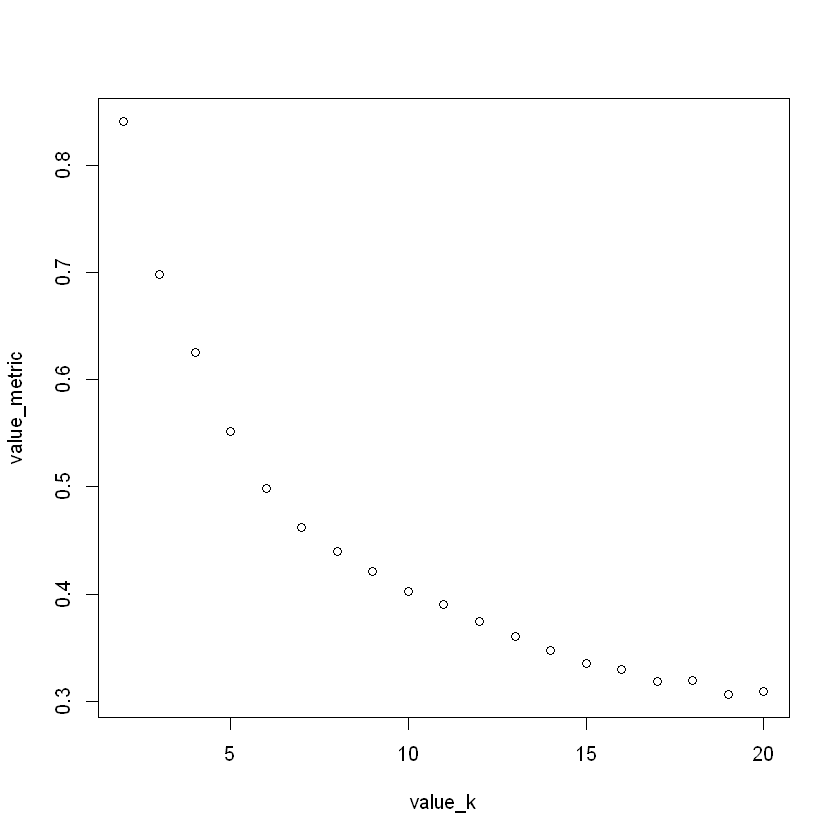

In [754]:
plot(value_k, value_metric) 

- K-means Clustering - 

The goal is to minimize the variance withing the cluster (within_SS) and maximize the variance between the clusters (between_SS), hence to maximize between_ss/total_ss. as a results we will get high similarity within each group, and low similarity between each group. (or untill I see some reasonable clusters for our goal) 

Here K-means algorithm is computed for different values of k

In [755]:
set.seed(8)
#seg.k <- kmeans(train, centers=7) 
#seg.k <- kmeans(train, centers=11) 
#seg.k <- kmeans(train, centers=10)

#seg.k <- kmeans(train, centers=14) 
#seg.k <- kmeans(train, centers=12)
seg.k <- kmeans(train, centers=13, nstart=30) #(between_SS / total_SS =  64.4 %)
#seg.k <- kmeans(train, centers=8)



Warning message:
"did not converge in 10 iterations"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 8153250)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 8153250)"Warning message:
"did not converge in 10 iterations"Warning message:
"did not converge in 10 iterations"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 8153250)"Warning message:
"did not converge in 10 iterations"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 8153250)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 8153250)"Warning message:
"did not converge in 10 iterations"Warning message:
"did not converge in 10 iterations"Warning message:
"did not converge in 10 iterations"Warning message:
"did not converge in 10 iterations"Warning message:
"did not converge in 10 iterations"Warning message:
"did not converge in 10 iterations"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 8153250)"Warning message:
"Quick-TRANSfer sta

In [758]:
seg.k

K-means clustering with 13 clusters of sizes 26626, 5802, 14112, 2256, 7900, 41775, 9511, 4738, 22481, 2330, 8166, 7799, 9569

Cluster means:
   ratio.total.discharges ratio.average.covered.charges
1            -0.202613328                    0.05856420
2            -0.115057518                   -0.65875294
3            -0.074102837                   -0.08685730
4             4.286129159                    0.45682625
5            -1.358009798                   -1.45440823
6            -0.040875117                    0.03520935
7            -0.353117130                   -0.59625492
8            -0.696813112                   -0.51821902
9            -0.086848621                   -0.20158829
10            0.009473619                    2.91272147
11            0.894266149                    0.76676078
12           -0.485826366                    2.14536843
13            1.562458332                   -0.48538935
   ratio.average.total.payments ratio.average.medicare.payments numberofDR

For a more in-depth look at the clusters, I will examine the coordinates of the cluster centroid

In [757]:
seg.k$center

ratio.total.discharges,ratio.average.covered.charges,ratio.average.total.payments,ratio.average.medicare.payments,numberofDRGs,payments.to.charges
-0.202613328,0.05856420,0.01215732,0.01285845,-0.95609118,-0.4581990
-0.115057518,-0.65875294,0.07378219,0.11922605,0.07307718,3.3092302
-0.074102837,-0.08685730,0.03998847,0.05642138,-1.64053799,0.8461794
4.286129159,0.45682625,0.12963877,0.04693686,0.94734213,-0.1111316
-1.358009798,-1.45440823,-0.95715233,-0.87954230,-1.12275934,0.3736314
-0.040875117,0.03520935,-0.01577295,-0.03144015,0.62769858,-0.6141250
-0.353117130,-0.59625492,-1.77342597,-1.75984078,0.29201854,-0.2515432
-0.696813112,-0.51821902,2.60296462,2.79887048,-0.03139216,0.8832132
-0.086848621,-0.20158829,0.06015665,0.08120748,0.48321214,0.5626662
0.009473619,2.91272147,3.43768099,3.27316722,0.38746058,-0.2924072


(By examining whether the clusters fall above or below the mean level for each interest category, we can begin to notice patterns that distinguish the clusters from each other.

In [738]:
seg.k[7]

$size
 [1] 26626  5802 14112  2256  7900 41775  9511  4738 22481  2330  8166  7799
[13]  9569

In [718]:
library(cluster)
library(factoextra)

In [719]:
train <- as.data.frame(train)

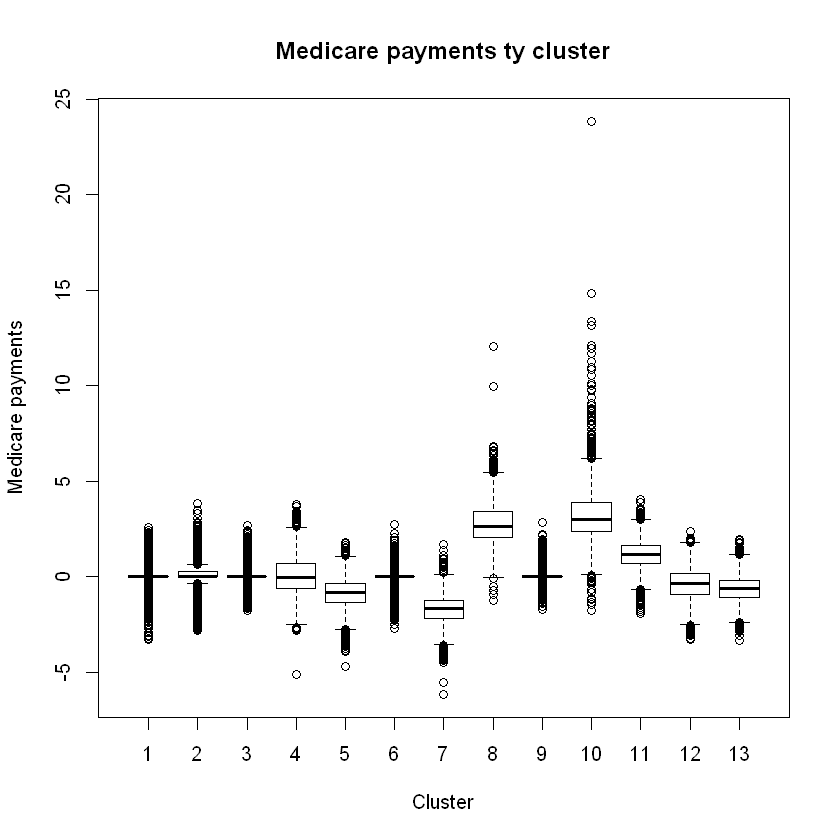

In [732]:
p1 <- boxplot(train$ratio.average.medicare.payments ~ seg.k$cluster,
        xlab='Cluster', ylab='Medicare payments',
        main='Medicare payments ty cluster')

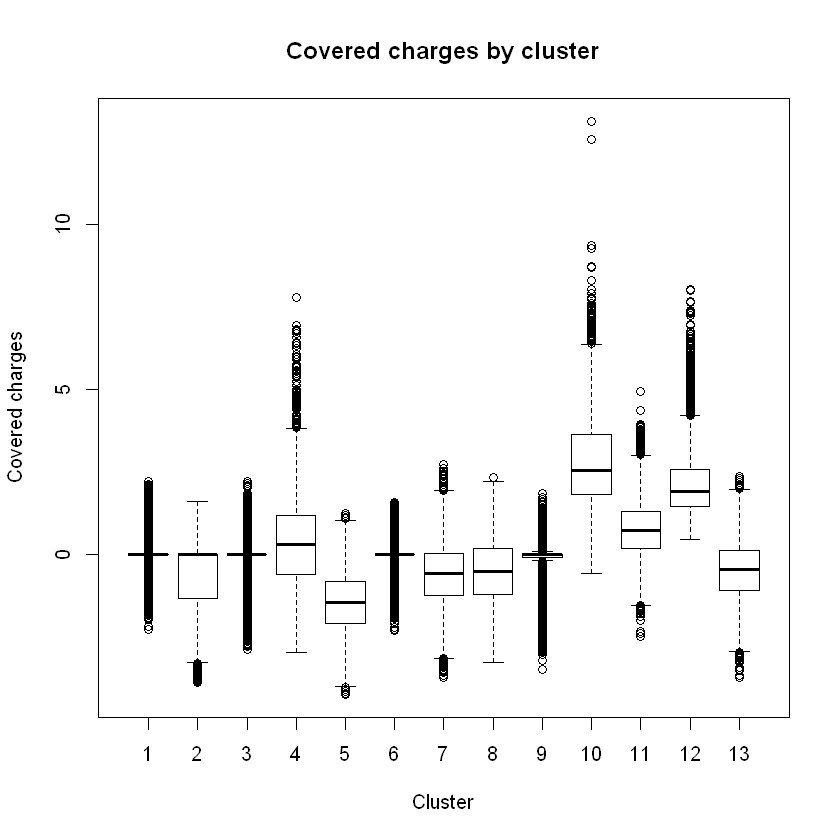

In [733]:
p2 <- boxplot(train$ratio.average.covered.charges ~ seg.k$cluster,
        xlab='Cluster', ylab='Covered charges',
        main='Covered charges by cluster')

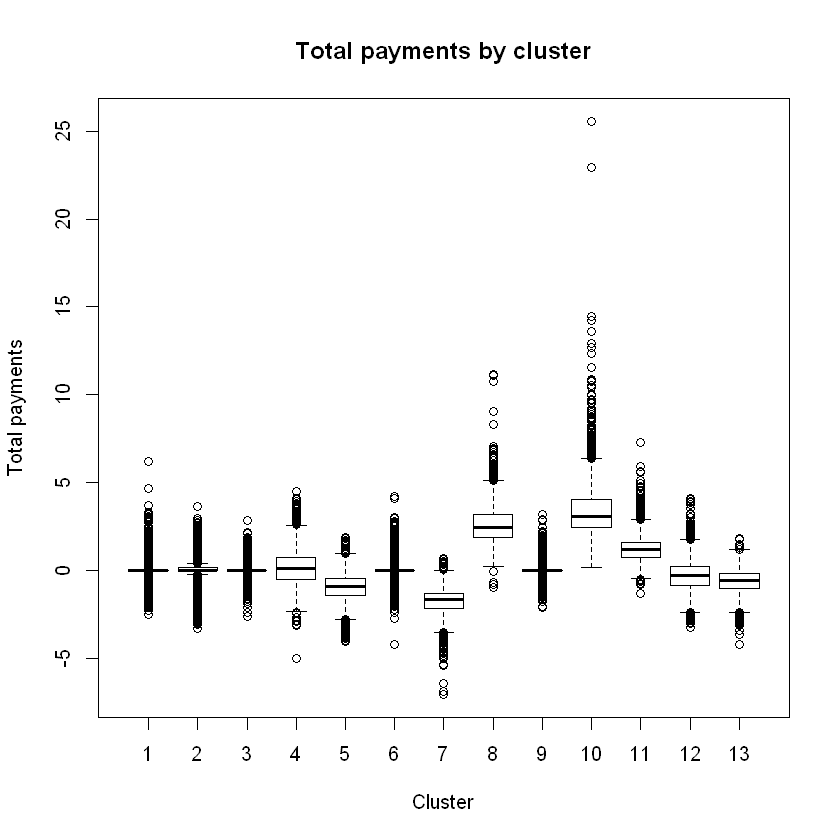

In [734]:
p3 <- boxplot(train$ratio.average.total.payments ~ seg.k$cluster,
        xlab='Cluster', ylab='Total payments',
        main='Total payments by cluster')

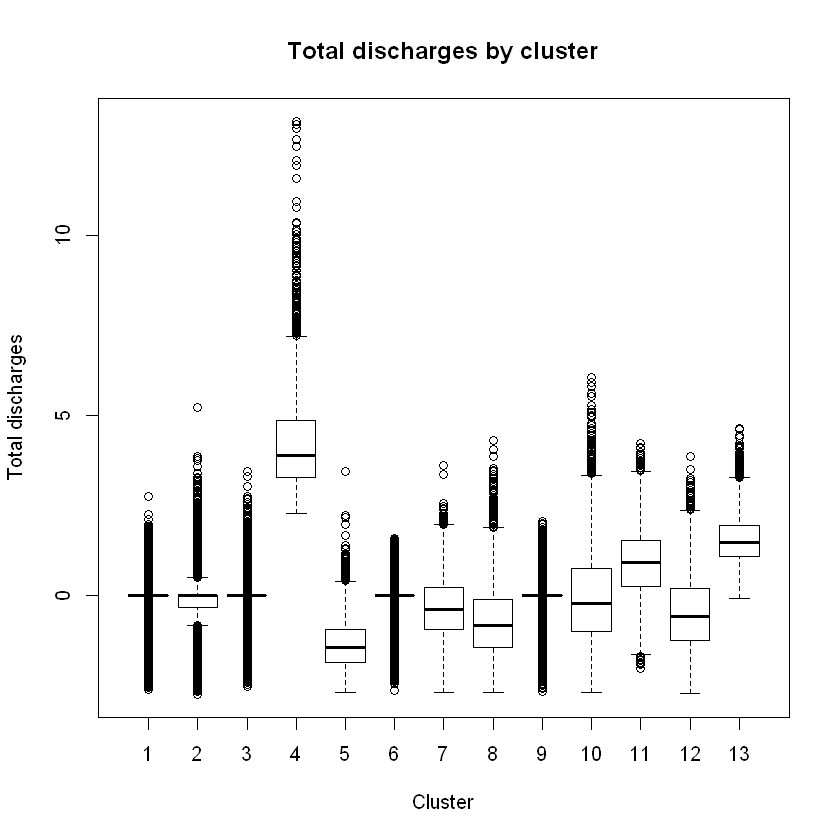

In [735]:
p4 <- boxplot(train$ratio.total.discharges ~ seg.k$cluster,
        xlab='Cluster', ylab='Total discharges',
        main='Total discharges by cluster')

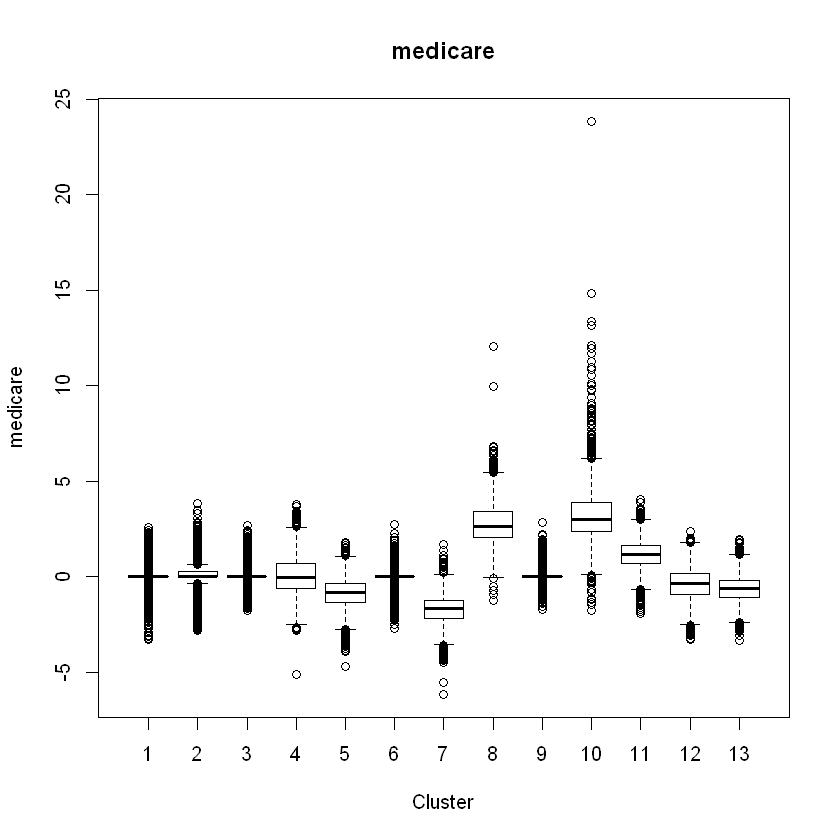

In [730]:
p4 <- boxplot(train$ratio.average.medicare.payments ~ seg.k$cluster,
        xlab='Cluster', ylab='medicare',
        main='medicare')

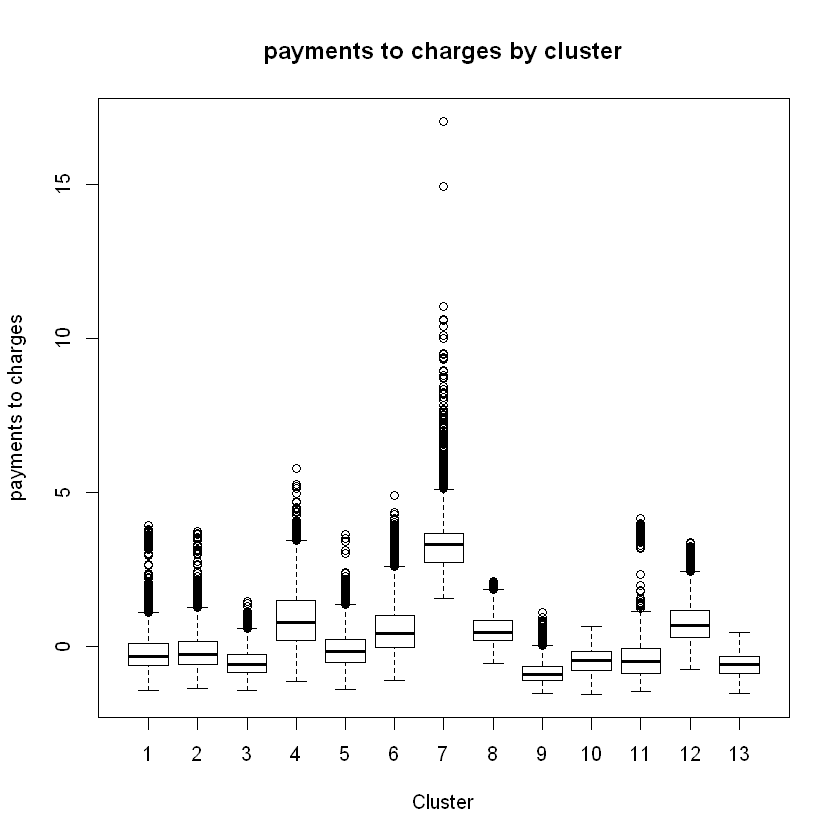

In [725]:
p5 <- boxplot(train$payments.to.charges ~ seg.k$cluster,
        xlab='Cluster', ylab='payments to charges',
        main='payments to charges by cluster')

- Smallest clusters are particulary our target,in this case I find cluster 11 interesting - 
- cluster 11 consists of less around 3% of the records, has the highest : "ratio.average.covered.charges", "ratio.average.total.payments", and "ratio.average.medicare.payments".

- cluster 7 has unusually high payment over ratio and cluster 2 highest total discharges.

Overall, I think cluster 11 is interesting, however I would farther revise variables and clasters to see more obvious results. 